# Experimenting with different models to create food classifcation app

Dataset used in this project: https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html

Note that data is reduced to 3 classes for simplicity of the experimenting

In [1]:
import torch
from torch import nn
from torchvision import datasets

from pathlib import Path

data_path = Path("data/")

train_dir = data_path / "pizza_steak_sushi/train"
test_dir = data_path / "pizza_steak_sushi/test"

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

# Check Data

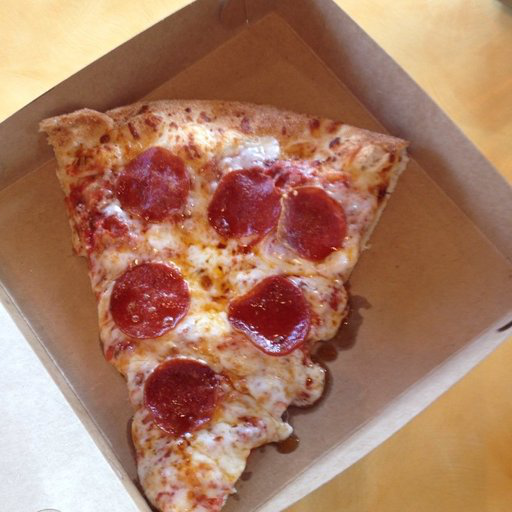

In [4]:
from PIL import Image

img_path = train_dir/ "pizza/1344966.jpg"
img = Image.open(img_path)

img

#Import pretrained model

In [6]:
import torchvision

weights = torchvision.models.MobileNet_V2_Weights.DEFAULT

transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
import data_loader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
  transforms.Resize((224, 224)), # MobileNet V2 has an image input size of 224-by-224
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ^^^ Using the same data transformation as the pretrained model
                         std=[0.229, 0.224, 0.225])
])

train_dataloader, test_dataloader, class_names = data_loader.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=32
)

In [8]:
model = torchvision.models.mobilenet_v2(weights=weights)

In [9]:
for param in model.features.parameters(): #Freeze feature extractor layers(conv)
    param.requires_grad = False

In [10]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=3,
                    bias=True))

In [11]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [12]:
#Forward pass

img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model.eval()
with torch.inference_mode():
    pred = model(img_single)

Single image shape: torch.Size([1, 3, 224, 224])



#Train Model

In [14]:
from torch.optim import Adam
from torch.optim import SGD

from flow import train

EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),0.001)

In [15]:
result = train(model, train_dataloader,test_dataloader,optimizer,loss_fn,EPOCHS)

# Evaluate

In [16]:
import matplotlib.pyplot as plt

def plot_curves_for_model(result):
  plt.figure(figsize=(10,12))

  plt.subplot(2,1,1)
  plt.plot(result["train_loss"], label="train loss")
  plt.plot(result["test_loss"], label="test loss")

  plt.legend()
  plt.title("Loss")

  plt.subplot(2,1,2)
  plt.plot(result["train_acc"], label="train accuracy")
  plt.plot(result["test_acc"], label="test accuracy")
    
  plt.legend()
  plt.title("Accuracy")

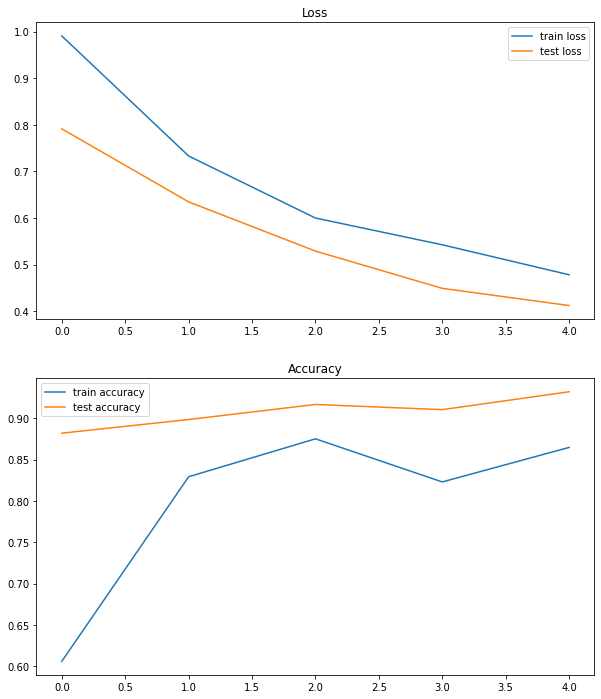

In [17]:
plot_curves_for_model(result)

In [18]:
img_batch, label_batch = next(iter(test_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model.eval()
with torch.inference_mode():
    pred = model(img_single)

    predicition = torch.softmax(pred.squeeze(), dim=0)

class_pred  = predicition.argmax()
class_pred, label_single

Single image shape: torch.Size([1, 3, 224, 224])



(tensor(0), tensor(0))

Probability: 0.86
Class name: pizza  , Predicted Label: pizza


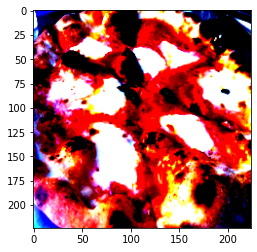

In [28]:
img_single = torch.squeeze(img_single,0)
img = img_single.permute(1,2,0)

print(f"Probability: {predicition[label_single]:.2f}")
print(f"Class name: {class_names[label_single]}  , Predicted Label: {class_names[class_pred]}")
plt.imshow(img)

# Save Model

In [29]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "Best_MobileNetV2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)